In [1]:

%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [2]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [20]:
#here we are taking image size of 400X400
def load_img(path):
    image = Image.open(path).convert('RGB')
    in_transform = transforms.Compose([transforms.Resize([400,400]),
                                     transforms.ToTensor()])
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [21]:
#load content image
content = load_img('./images/janelle.png').to(device)
#load style image 
style = load_img('./images/delaunay.jpg').to(device)

In [22]:
#function for converting tensor to numpy
def convert_image(image):
    img = image.to('cpu').clone().detach()
    
    img = img.numpy().squeeze()
    img = img.transpose(1,2,0)
    return img


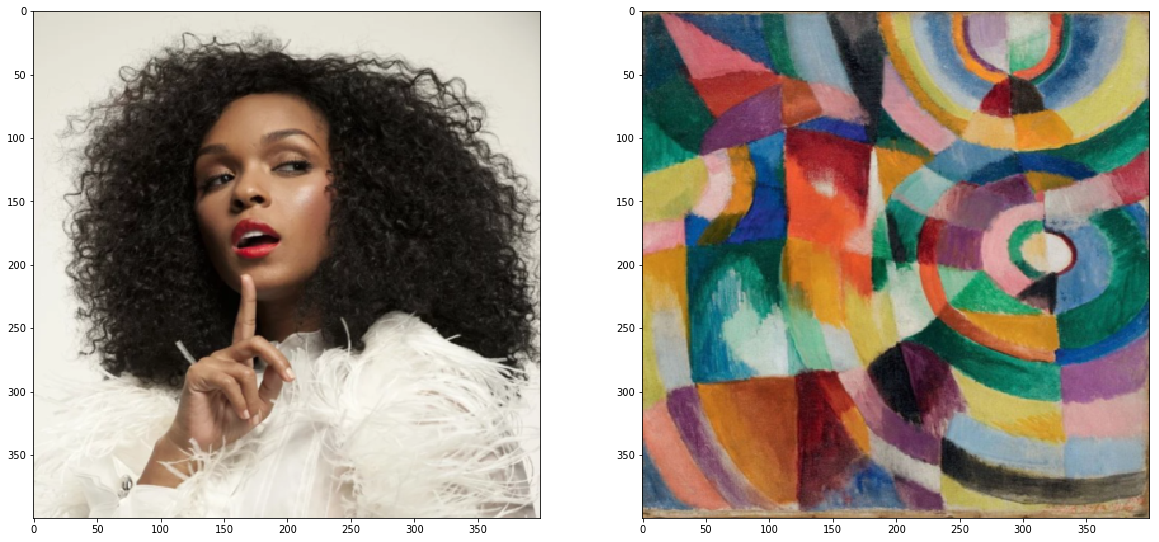

In [23]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(convert_image(content))
ax2.imshow(convert_image(style))

In [24]:
print(content.shape)
print(style.shape)

torch.Size([1, 3, 400, 400])
torch.Size([1, 3, 400, 400])


In [28]:
#create target image
target = content.clone()
target = target.requires_grad_(True).to(device)

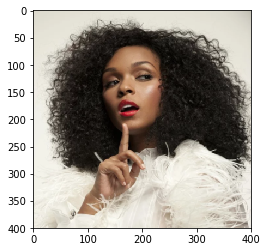

In [29]:
plt.imshow(convert_image(target))

In [41]:
def get_features(image,model):
    layers = {'0':'conv1_1',
          '5':'conv2_1',
          '10':'conv3_1',
          '19':'conv4_1',
          '21':'conv4_2',
          '28':'conv5_1'
             }
    features ={}
    x = image
    for name ,layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]]=x
            
    return features

In [31]:
vgg._modules.items()

odict_items([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace)), ('16', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('17', ReLU(inplace)), ('18', MaxPool2d(kernel_size=2, str

In [46]:
def gram_matrix(tensor):
    _,d,w,h = tensor.shape
    tensor= tensor.view(d,w*h)
    return torch.mm(tensor,tensor.t())

In [34]:
style_weights= {'conv1_1':1,
               'conv2_1':0.8,
               'conv3_1':0.5,
               'conv4_1':0.3,
               'conv5_1':0.1}
content_weight = 1
style_weight = 1e6


In [48]:
content_features =  get_features(content,vgg)
style_features = get_features(style,vgg)
#create gram matrix of style image
style_gram_matrix = {layer:gram_matrix(style_features[layer]) for layer in style_features}


In [45]:
style_features

{'conv1_1': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.8312, 0.7761,  ..., 0.8539, 0.8762, 1.5526],
           [0.0000, 0.3456, 0.2633,  ..., 0.4764, 0.4470, 1.6934],
           [0.0000, 0.3770, 0.1877,  ..., 0.6463, 0.4987, 1.7983],
           ...,
           [0.0000, 0.8567, 0.8198,  ..., 0.1521, 0.0867, 1.4796],
           [0.0000, 0.5864, 0.5783,  ..., 0.3002, 0.2150, 1.5393],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.3351]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0

Total Loss :  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(4116.8848, device='cuda:0', grad_fn=<ThAddBackward>)


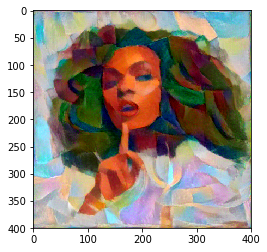

Total Loss :  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(3603.9395, device='cuda:0', grad_fn=<ThAddBackward>)


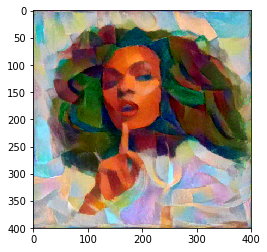

Total Loss :  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(3278.8796, device='cuda:0', grad_fn=<ThAddBackward>)


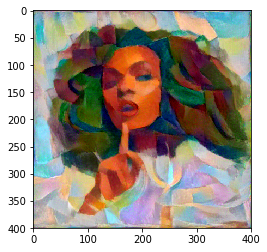

Total Loss :  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2939.1873, device='cuda:0', grad_fn=<ThAddBackward>)


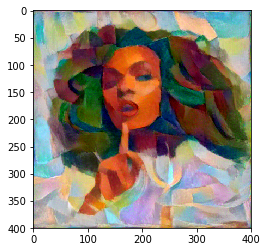

Total Loss :  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(3131.3591, device='cuda:0', grad_fn=<ThAddBackward>)


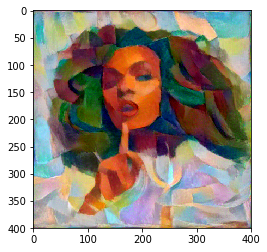

Total Loss :  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2594.7424, device='cuda:0', grad_fn=<ThAddBackward>)


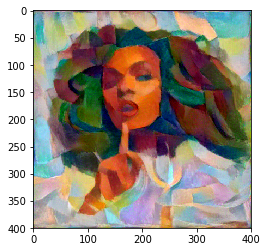

Total Loss :  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2459.3284, device='cuda:0', grad_fn=<ThAddBackward>)


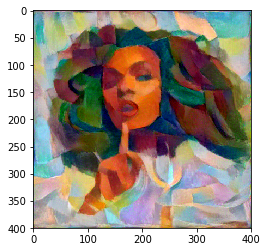

Total Loss :  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2421.3523, device='cuda:0', grad_fn=<ThAddBackward>)


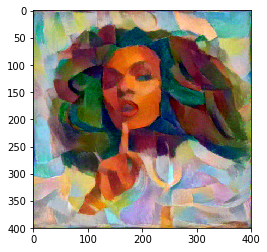

Total Loss :  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2317.2446, device='cuda:0', grad_fn=<ThAddBackward>)


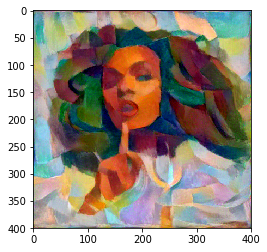

Total Loss :  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2490.3286, device='cuda:0', grad_fn=<ThAddBackward>)


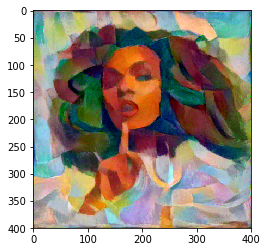

Total Loss :  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2162.4871, device='cuda:0', grad_fn=<ThAddBackward>)


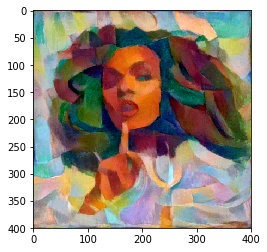

Total Loss :  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2153.1836, device='cuda:0', grad_fn=<ThAddBackward>)


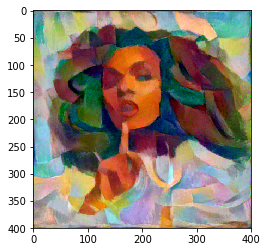

In [52]:
epochs = 5000
showat = 400
optimizer = optim.Adam([target],lr=0.003)
for e in range(1,epochs+1):
    target_features = get_features(target,vgg)
    content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_weights:
        target_feature =  target_features[layer]
        _,d,w,h = target_feature.shape
        target_gram = gram_matrix(target_feature)
        
        style_loss_layer = torch.mean((target_gram-style_gram_matrix[layer])**2)/2
        
        style_loss += (style_weights[layer]*style_loss_layer)/(d*w*h)
        
    total_loss = content_weight*content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if e %showat ==0:
        print("Total Loss : ",total_loss)
        plt.imshow(convert_image(target))
        plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


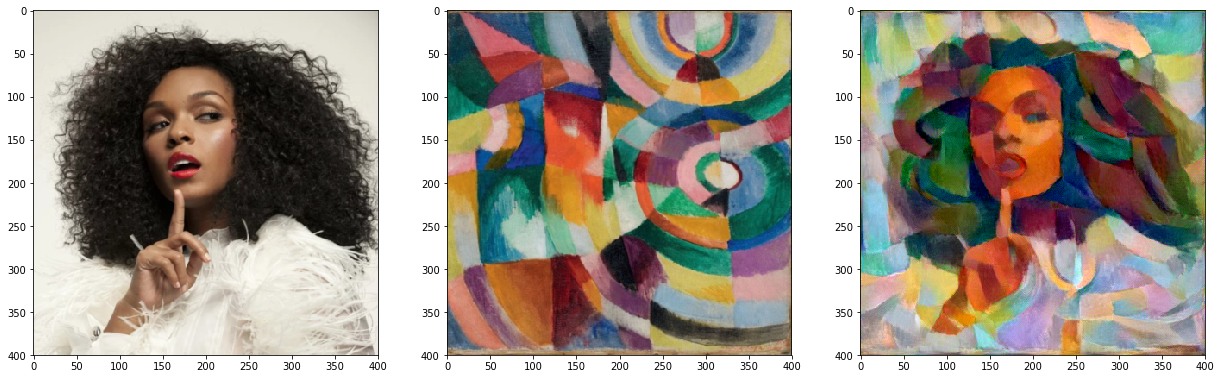

In [54]:
# display the images
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(21, 10))
# content and style ims side-by-side
ax1.imshow(convert_image(content))
ax2.imshow(convert_image(style))
ax3.imshow(convert_image(target))